In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import matplotlib.patches as patches

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import os
import json
import time
from io import StringIO
from datetime import datetime
import re
import math

from sklearn.linear_model import LinearRegression
from scipy import integrate
from scipy.signal import find_peaks

import sys
sys.path.append("/Users/dteng/Documents/bin/nmr_utils/")
from nmr_targeted_utils import *
from nmr_fitting_funcs import *


In [2]:
# ===== params =====
template_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/indiv_std_lproline/lproline_ph3.csv"
path_samples = "/Users/dteng/Documents/zdata/nmr/J202208B_pro_survey/training_set_csvs/"
bs_grad_path = "/Users/dteng/Documents/nmr_targeted/mlgrad/results/bootstrap_results.csv"
matching_path = "/Users/dteng/Documents/zdata/nmr/nmr_std_data/lr_matching_coords/lproline_ph3_matching_regions.csv"

# diff mcoords for neat-pro-std or pro_std_03
if "pro_std_03" in template_path:
    multiplets_ls = [[1.9,2.15], [2.304, 2.408],[3.25, 3.5],[4.1, 4.2]]
if "lproline_ph3" in template_path:
    multiplets_ls = [[1.9,2.15], [2.295, 2.403], [3.25, 3.5],[4.1, 4.2]]

normxcorr_th = 0.0 # set to this number to filter out multiplets which aren't at least normxcorr_th, i.e. poor fits
ref_pk_window = [-0.2, 0.2]
ref_pk_tolerance_window = [0,0]
search_region_padding_size = 0.02

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
folder_name = f"./results/mlgrad_fitting-{template_path.split('/')[-1].replace('.csv', '')}-{timestamp}"
fn_out_plot = "training_fit_viz.html"

print(f"results folder = {folder_name}")

# ========== load data ==========
# load STD template(s)
template_df = pd.read_csv(template_path)
template_df = adjust_to_ref_peak(template_df, ref_pk_window, ref_pk_tolerance_window)

# load sample (training) data - only QCs and Rs
df_dict = {}
for fn in os.listdir(path_samples):
    if ".csv" in fn:
        k = fn.split(".")[0].replace("_QC", "_Q")
        df_dict[k] = pd.read_csv(os.path.join(path_samples, fn))
print(f"Loaded {len(df_dict)} samples.")

matching_regions_ls = [
    [2.305, 2.306],
    [2.31, 2.316],
    [2.321, 2.3225],
    [2.331, 2.333],
    [2.337, 2.339],
    [2.342, 2.3445],
    [2.347, 2.349],
    [2.3585, 2.3605],
    [2.365, 2.3675],
    [2.3755, 2.3765],
    [2.381, 2.39]]

matching_regions_ls2 = [
    [2.3, 2.4]
]

results folder = ./results/mlgrad_fitting-lproline_ph3-20240429_1116
Loaded 128 samples.


In [3]:
# ===== run 1d_std_search =====
results_dict = {}
for k in sorted(list(df_dict.keys())):
    target_df = df_dict[k]
    results_dict[k] = do_1d_std_search(
        query_df=template_df,
        target_df=target_df,
        multiplets_ls=multiplets_ls,
        search_region_padding_size=search_region_padding_size
    )

# get reds
red_dt = template_df.copy()
red_dt = red_dt.loc[(red_dt["ppm"]>min(multiplets_ls[1])) & (red_dt["ppm"]<max(multiplets_ls[1]))]

# get blues
blue_m1_dict = get_blue_m1_dict(results_dict, 
                                df_dict,
                                mcoords=multiplets_ls[1]
                               )

# ===== get corr_series_dict =====
# get corr_series for each k, stored in corr_series_dict
corr_series_dict = {}
for k in sorted(list(results_dict.keys())):
    dt = get_correlation_series(red_dt, 
                                blue_m1_dict[k].copy(),
                                min_corr=0, 
                                min_corr_replacement_value=0,
                                window_size_nrows=64,
                                exponent=8
                               )
    corr_series_dict[k] = dt

# ===== run LR matching =====
df_conc = get_df_conc_lrmatching(
    results_dict=results_dict, 
    template_df=template_df.copy(), 
    df_dict=df_dict, 
    mcoords=multiplets_ls[1],
    matching_coords_ls=matching_regions_ls,
    corr_series_dict=corr_series_dict
)


In [5]:
selected_sample_names_ls = ["AF61396_R2", "AF60343_Q2", "AF63540_R1"]
# do LR without specified matching regions
selected_lr_dict = {}
for k in selected_sample_names_ls:
    blue_dt = blue_m1_dict[k].copy()
    
    model = LinearRegression()
    model.fit(red_dt.intensity.values.reshape(-1, 1), 
              blue_dt.intensity.values
              )

    subdict = {"intercept":model.intercept_, 
              "slope":model.coef_[0]}
    selected_lr_dict[k] = subdict


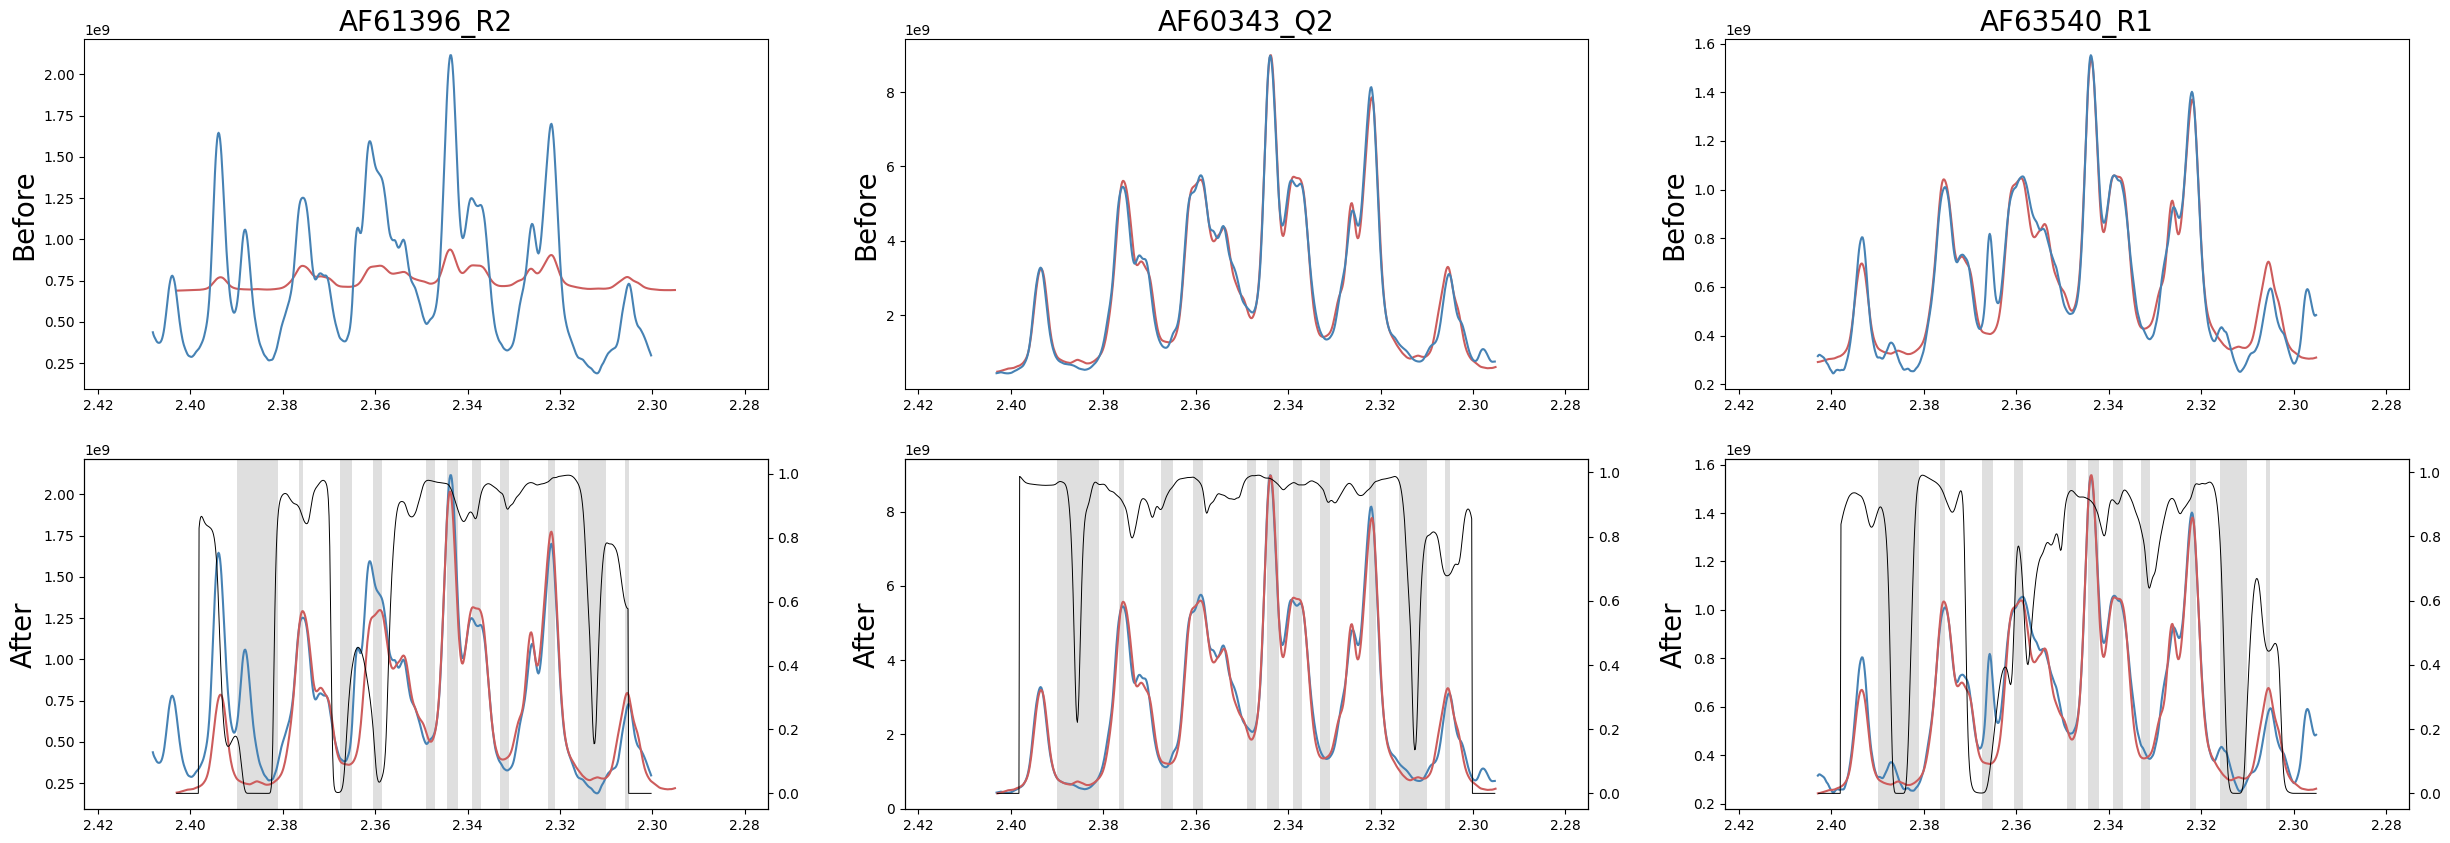

In [10]:
# ===== plot match results =====
fig, ax = plt.subplots(nrows=2,
                       ncols=len(selected_sample_names_ls), 
                       figsize=(30, 10)
                      )

mcoords_xl = [
    min(multiplets_ls[1]) - search_region_padding_size, 
    max(multiplets_ls[1]) + search_region_padding_size, 
]

# plot fit
for i in range(len(selected_sample_names_ls)):
    k = selected_sample_names_ls[i]
    
    # ===== plot "before" =====
    # get LR params
    m0 = selected_lr_dict[k]["slope"]
    c0 = selected_lr_dict[k]["intercept"]
    blue_dt = blue_m1_dict[k].copy()

    # plot!
    ax[0, i].plot(red_dt.ppm.values, 
                  (red_dt.intensity.values*m0)+c0, 
                  c="indianred"
                 )
    ax[0, i].plot(blue_dt.ppm.values, 
                  blue_dt.intensity.values,
                  c="steelblue"
                 )

    #ax[1, i].set_title(f"{k}\nnormxcorr={round(normxcorr, 4)}", fontsize=20)
    
    # ===== plot "after" =====
    normxcorr = results_dict[k]["multiplet_1"]["max_rho"][0]
    ax[1, i].plot(blue_m1_dict[k].ppm.values, 
            blue_m1_dict[k].intensity.values, c="steelblue")
    
    m = df_conc.loc[df_conc["sample_name"]==k]["slope"].values[0]
    c = df_conc.loc[df_conc["sample_name"]==k]["intercept"].values[0]
    ax[1, i].plot(red_dt.ppm.values, 
            (red_dt.intensity.values*m)+c, 
            c="indianred")
    
    # plot sliding window of correlation
    ax2 = ax[1, i].twinx()
    ax2.plot(corr_series_dict[k]["ppm"], 
             corr_series_dict[k]["corr_series"], 
             lw=0.7,
             c="k")
    
    # set bg colour
    transparency = 0.65
    bg_colour = (1, 159/255, 165/255, transparency) # red
    if normxcorr >= 0.85 and normxcorr < 0.9:
        bg_colour = (1, 184/255, 100/255, transparency) # orange
    if normxcorr >= 0.9 and normxcorr < 0.95:
        bg_colour = (1, 242/255, 100/255, transparency) # yellow     
    if normxcorr >= 0.95 and normxcorr < 0.99:
        bg_colour = (150/255, 1, 153/255, transparency) # green
    elif normxcorr >= 0.99:
        bg_colour = (140/255, 220/255, 1, transparency) # light blue
    # ax[1, i].set_facecolor(bg_colour)
    # plt.setp(ax[1, i].get_xticklabels(), fontsize=20)
    # plt.setp(ax[1, i].get_yticklabels(), fontsize=20)
    
    # draw matching regions
    rect_height = ax[1, i].get_ylim()[1]
    for row in matching_regions_ls:
        # Create a rectangle patch
        rect = patches.Rectangle((min(row), 0), 
                                 max(row) - min(row), 
                                 rect_height, 
                                 edgecolor=None,
                                 facecolor='grey', 
                                 alpha=0.25)
    
        # Add the rectangle patch to the plot
        ax[1, i].add_patch(rect)

    # final bits
    ax[0, i].set_xlim([max(mcoords_xl), min(mcoords_xl)])
    ax[1, i].set_xlim([max(mcoords_xl), min(mcoords_xl)])
    ax[0, i].set_title(k, fontsize=20)
    ax[0, i].set_ylabel(f"Before", fontsize=20)
    ax[1, i].set_ylabel(f"After", fontsize=20)


plt.savefig(f"./figs/before_n_after.png", dpi=300)